In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import datetime
import os
import glob
import sys
from utils import *


from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, metrics


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten, Reshape
from keras.layers import LSTM,GRU
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing import sequence
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Conv2D, AveragePooling1D, MaxPooling2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.utils import multi_gpu_model


sns.set(style="darkgrid")
import dsmuc.io as io
import dsmuc.preprocessing as pp
import dsmuc.features as ff
import dsmuc.custom as cs

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Inputs

In [2]:
raw_windows_path = "/home/ahmet/notebooks/data/G9_data/Raw/snippets/"
processed_file_path = "/home/ahmet/notebooks/data/G9_data/processed.csv"

In [3]:
columns = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']

In [4]:
win_paths = glob.glob(raw_windows_path+'*/*.csv')
print("Found {} windows".format(len(win_paths)))

Found 34519 windows


In [5]:
win_list = [pd.read_csv(win_paths[i], index_col='date', parse_dates=True) for i in range(len(win_paths))]

In [6]:
len(win_list)

34519

In [7]:
win_list[1].head()

,accX,accY,accZ,gyroX,gyroY,gyroZ,subject_id,label
date,,,,,,,,
2017-12-20 07:21:47.028,-9.797073,-2.552219,0.057461,0.044500,0.098412,0.390070,11,5
2017-12-20 07:21:47.051,-9.797073,-2.533065,0.071826,0.030651,0.086162,0.327219,11,5
2017-12-20 07:21:47.055,-9.619903,-2.542642,0.167594,0.001889,0.083498,0.255847,11,5
2017-12-20 07:21:47.081,-9.543288,-2.537854,0.177171,-0.018883,0.077107,0.180213,11,5
2017-12-20 07:21:47.095,-9.504981,-2.523489,0.215478,-0.023677,0.069650,0.108307,11,5


In [8]:
def get_raw(win_list):
    # Get data in raw format for models
    
    win_len = len(win_list)
    X , y , s=[], [], []
    for win in win_list:
        # Append data, label and subject id 
        X.append(win[columns].values)
        y.append(win['label'][0])
        s.append(win['subject_id'][0])
    return np.array(X), np.array(y), np.array(s)

def get_processed(processed_file_path):
    # Get Processed data to use in models
    
    df = pd.read_csv(processed_file_path)
    df.dropna(axis=0, how='any', inplace=True)
    X = df[df.columns[:-3]].values
    y = df['label']
    s = df['subject_id']
    return X, y, s 
    

In [9]:
X_raw, y_raw, s_raw = get_raw(win_list)

In [10]:
X_prep, y_prep, s_prep = get_processed(processed_file_path)

## CNN

In [11]:
def CNN1():
    # 77% accuracy
    model = Sequential()
    model.add(Conv1D(8,
                    64,
                     input_shape=(timesteps,1),
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=9))
    model.add(Conv1D(16,
                    16,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size = 7))
    model.add(Conv1D(64,
                    4,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    
    return model

def CNN2():
    # 77% accuracy
    model = Sequential()
    model.add(Conv2D(8,
                    (64,3),
                     input_shape=(timesteps,6,1),
                     padding='valid',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(4,1)))
    model.add(Conv2D(16,
                    (16,3),
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling2D(pool_size=(1,2)))
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    
    return model

## RNN

In [12]:
def RNN1():
    # 85% accuracy
    model = Sequential()
    model.add(Conv1D(8,
                    64,
                     input_shape=(timesteps,1),
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(16,
                    16,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Conv1D(64,
                    4,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(LSTM(64))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    
    return model
def RNN2():
    # 85% accuracy
    model = Sequential()
    model.add(Conv2D(8,
                    (64,3),
                     input_shape=(timesteps,6,1),
                     padding='valid',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(4,1)))
    model.add(Conv2D(16,
                    (16,3),
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling2D(pool_size=(1,2)))
    model.add(Reshape(target_shape=(1,16)))   
    model.add(LSTM(64))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    
    return model

## MLP

In [13]:
def MLP():
    model = Sequential()
    model.add(Dense(512, input_shape =(timesteps,)))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256))
    model.add(Dense(256))
    model.add(Dense(32))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()
    return model

In [14]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
selected_model = 'LogReg'

raw_models = ['CNN1', 'MLP', 'RNN1', 'CNN2', 'RNN2']
#LOO-Validation on each subject
if selected_model in raw_models:
    X = X_raw
    y = y_raw
    s = s_raw
else:
    X = X_prep
    y = y_prep
    s = s_prep
    
subject_list = np.unique(s_raw)
y_test_all = []
y_pred_all = []
y_score_all = []
# np.random.seed(44)
iterations = shuffle(np.array(list(itertools.combinations(subject_list, 2))))

it_index = iterations[:40]
for subject in it_index: # two combination of tested subjects
    if os.path.exists('weights.hdf5'):
        os.remove('weights.hdf5')
    print("==================")
    print('Model tested on subjects with no : ', subject)
    mask_test = np.logical_or(s==subject[0], s== subject[1])
    mask_training = np.logical_and(s!=subject[0], s!= subject[1])
    X_test = X[mask_test]
    y_test = y[mask_test] -1
    X_training = X[mask_training] 
    y_training = y[mask_training] -1
    print("Test set and training set proportion : ",float(X_test.shape[0])/X_training.shape[0] )
    
    class_weight = get_class_weights(y_training)

    if not selected_model in raw_models : # Models will train on processed features
        if selected_model == "LogReg":
            model = LogisticRegression(class_weight = class_weight)
        elif selected_model == "SVM":
            model = svm.SVC( class_weight = class_weight, probability=True)
        elif selected_model == 'RForest':
            model = RandomForestClassifier(max_depth=10, n_estimators=20, class_weight=class_weight)
        
        model.fit(X_training, y_training)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
    else: # Models will train on raw data
        callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=25,
                              verbose=0, mode='auto'),
            keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)]
        
        X_training = keras.preprocessing.sequence.pad_sequences(X_training, maxlen=128, dtype='float64',
            padding='pre', truncating='pre', value=0.)
        X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=128, dtype='float64',
            padding='pre', truncating='pre', value=0.)
        
        batch_size = 1500
        n_classes = 6
        
        if selected_model =='CNN1':
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_training = X_training.reshape(train_shape[0], -1,1)
            X_test = X_test.reshape(test_shape[0], -1,1)
            timesteps = len(X_training[0])
            model = CNN1()
        elif selected_model =='CNN2':
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_training = X_training.reshape(train_shape+(1,))
            X_test = X_test.reshape(test_shape+ (1,))
            timesteps = len(X_training[0])
            model = CNN2()
        elif selected_model =='RNN1':
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_training = X_training.reshape(train_shape[0], -1,1)
            X_test = X_test.reshape(test_shape[0], -1,1)
            timesteps = len(X_training[0])
            model = RNN1()
        elif selected_model =='RNN2':
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_training = X_training.reshape(train_shape+(1,))
            X_test = X_test.reshape(test_shape+ (1,))
            timesteps = len(X_training[0])
            model = RNN2()
        elif selected_model =='MLP':
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_train = X_train.reshape(train_shape[0], -1)
            X_test = X_test.reshape(test_shape[0], -1)
            timesteps = len(X_training[0])
            model = MLP()
            
        # Compile model
#         multi_model = multi_gpu_model(model = model, gpus = 1)
        model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
        history =model.fit(X_training,
                  one_hot(y_training),
                  batch_size=batch_size,
                  validation_data=(X_test, one_hot(y_test)),
                  epochs=100,
                  callbacks=callbacks)
        
        model.load_weights('weights.hdf5')
        y_pred = model.predict(X_test).argmax(1)
        y_score = model.predict(X_test)
        print("")
        
    y_score_all.extend(y_score)
    y_test_all.extend(list(y_test))
    y_pred_all.extend(list(np.argmax(pd.rolling_mean(y_score, 50,min_periods=1), axis=1)))
    '''plt.figure()
    plt.plot(pd.rolling_mean( y_score, 50,min_periods=1), "-")
    plt.xlim([0, 1.5*len(y_score)])
    plt.legend(['walking',
            'walking upstairs',
            'walking downstairs',
            'sitting',
            'standing',
            'laying'], loc='upper_left')
    a = np.asarray(y_test).astype(np.int)
    y_ticks = np.asarray(['walking',
            'walking upstairs',
            'walking downstairs',
            'sitting',
            'standing',
            'laying'])[a]
    plt.plot(y_ticks)
    plt.xlim([0, 1.5*len(y_score)])'''
#     plt.savefig('Figures/'+str(subject[0])+'_'+str(subject[1])+'.png')

Model tested on subjects with no :  [114 115]
Test set and training set proportion :  0.03541402148176109


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:118: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


Model tested on subjects with no :  [  7 102]
Test set and training set proportion :  0.04289368173648555
Model tested on subjects with no :  [  9 104]
Test set and training set proportion :  0.028216050434486283


In [1]:
label_dict = {1:'walking',
             2:'walking_upstairs',
             3:'walking_downstairs',
             4:'sitting',
             5:'standing',
             6:'laying'}
class_names = list(label_dict.values())


cnf_matrix = confusion_matrix(y_test_all, y_pred_all)
np.set_printoptions(precision=2)

save_with_name = selected_model
# Plot non-normalized confusion matrix
plt.figure()
plot_cm(cnf_matrix, class_names, normalize=False)

# Plot normalized confusion matrix
plt.figure()
plot_cm(cnf_matrix, class_names, normalize=True)
plt.savefig(save_with_name+'.png')
plt.show()

NameError: name 'confusion_matrix' is not defined

In [114]:
true_pos = np.diag(cnf_matrix).sum()
accuracy = true_pos/float(cnf_matrix.sum())
print('Overall accuracy of the Model', accuracy)

Overall accuracy of the Model 0.7818883517854358


In [115]:
from sklearn.metrics import classification_report
print(classification_report(y_test_all, y_pred_all,target_names=class_names))

                    precision    recall  f1-score   support

           walking       0.93      0.71      0.81      2686
  walking_upstairs       0.72      0.78      0.75      4024
walking_downstairs       0.80      0.75      0.78      3839
           sitting       0.76      0.86      0.81      7360
          standing       0.84      1.00      0.91      3624
            laying       0.73      0.53      0.61      4119

       avg / total       0.78      0.78      0.78     25652



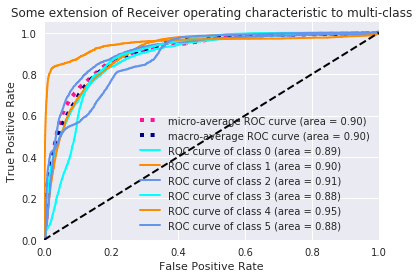

In [116]:
auc_roc_plot(one_hot(np.array(y_test_all)), np.array(y_score_all), None)